***Setup***

In [ ]:
! pip install -q bitsandbytes datasets accelerate loralib
! pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git
! pip install optimum auto-gptq
! pip install seaborn
! pip install wandb
! pip install flash-attn --no-build-isolation
! pip install scipy ipywidgets
! pip install ctransformers

In [ ]:
# IMPORTS
import os
import wandb
import pandas as pd
import seaborn as sns
from random import shuffle
import transformers, torch
from huggingface_hub import notebook_login

from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

In [ ]:
# HuggingFace Login
notebook_login()

In [ ]:
# Weights And Biases Login
wandb.login()
wandb.init(project="OpsHarmonySentinel")

In [2]:
PROJECT_DIR_PATH = ''
OUTPUT_PATH = os.path.join(PROJECT_DIR_PATH, 'model', 'files')

In [3]:
DEVICE = 'cuda'

BASELINE_MODEL_NAME = 'upstage/SOLAR-10.7B-Instruct-v1.0'
# BASELINE_MODEL_NAME = 'HuggingFaceH4/zephyr-7b-beta'

PROJECT_NAME = 'OpsHarmonySentinel'
HUGGING_FACE_REPO_NAME = f'imTheGodFather/{PROJECT_NAME}'
HUGGING_FACE_MERGED_REPO_NAME = f'{HUGGING_FACE_REPO_NAME}'
HUGGING_FACE_GPTQ_REPO_NAME = f'{HUGGING_FACE_REPO_NAME}'

***Prepare Dataset***

In [4]:
train_path = "/home/paperspace/documents/OpsHarmonySentinel/data/files/train.csv"
df = pd.read_csv(train_path)

In [5]:
# Get tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(BASELINE_MODEL_NAME,
                                                       padding_side='left',
                                                       add_eos_token=True
                                                       )
tokenizer.pad_token = tokenizer.eos_token

In [6]:
def text_to_dialogue(text):
    return [sentence.replace('User:', '').replace('Chip:', '').strip() for sentence in text.split('Assistant:')]

def dialogue_to_chat(dialogue):
    out = [{'role': 'system', 'content': 'You are a friendly chatbot assistant made by HEAL. You are an expert in ITOps, servers, applications and all other related domains.'}]
    # for idx, message in enumerate(dialogue):
    #     role = 'user' if idx%2==0 else 'assistant'
    #     out.append({'role': role, 'content': message})
    input = f"Investigate and provide root cause for the following incident - {dialogue['incident']}"
    out.append({'role': 'user', 'content': input})
    out.append({'role': 'assistant', 'content': dialogue['root_cause']})
    return out

def chat_to_input(chat):
    return tokenizer.apply_chat_template(chat, tokenize=False)

def process_example(example):
    # out = text_to_dialogue(example)
    out = dialogue_to_chat(example)
    out = chat_to_input(out)
    return out

In [7]:
data = [process_example(row) for idx, row in df.iterrows()]

In [8]:
print(data[69])

### System:
You are a friendly chatbot assistant made by HEAL. You are an expert in ITOps, servers, applications and all other related domains.

### User:
Investigate and provide root cause for the following incident - [
    {
        "incidentId": "E-99-9-999-9999999999",
        "incidentStartTime": "04/01/2023 08:30",
        "probabilityScore": 0.90,
        "anomalyId": "AE-99-9999-9-F-S-ALL-99999999",
        "anomalyTimestamp": "04/01/2023 08:30",
        "applicationId": "affected-app",
        "instanceId": "linux-server-42",
        "serviceId": "affected-service",
        "kpi": "INODES_USAGE",
        "value": 100.0,
        "thresholds": {"Upper": 99.0, "Lower": 0.0},
        "violationType": "Greater Than",
        "tags": [
            {"kpi": "Inodes"},
            {"kpiCategory": "FileSystem"},
            {"kpiType": "Count"},
            {"anomalyLevel": "INSTANCE"},
            {"severity": "CRITICAL"}
        ],
        "components": [
            {"operatingSystem

In [9]:
shuffle(data)

In [10]:
tokenized_data = list(map(tokenizer, data))

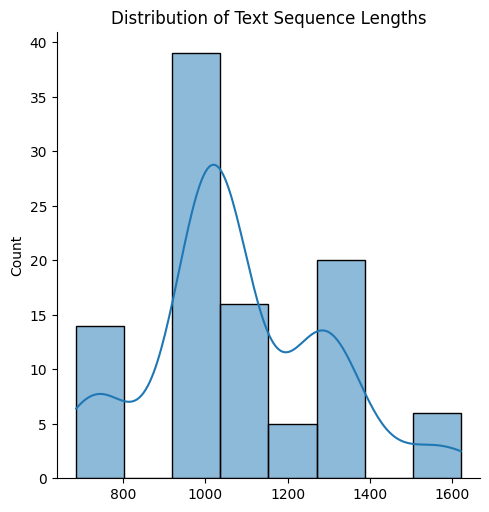

In [12]:
# Plot sequence Lengths
input_lengths = [len(x['input_ids']) for x in tokenized_data]
sns.displot(input_lengths, kde=True).set(title='Distribution of Text Sequence Lengths')

In [13]:
# Split dataset
split_idx = int(.99 * len(data))
train_data, val_data = tokenized_data[:split_idx], tokenized_data[split_idx:]

***Finetune a Quantized model***

In [ ]:
# Get quantized model
model = transformers.AutoModelForCausalLM.from_pretrained(BASELINE_MODEL_NAME,
                                                          load_in_8bit=True,     # call for the 8 bit bnb quantized version
                                                          device_map='auto'
                                                          )

In [15]:
# Get tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(BASELINE_MODEL_NAME,
                                                       padding_side='left',
                                                       add_eos_token=True
                                                       )
tokenizer.pad_token = tokenizer.eos_token

In [16]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=2)
    (layers): ModuleList(
      (0-47): 48 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear8bitLt(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
    

In [17]:
# Set PEFT adapter config (16:32)
config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],                             # Apply to "q_proj", "v_proj" layers of attention (as suggested by paper)
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM")

In [18]:
# stabilize output layer and layernorms
model = prepare_model_for_kbit_training(model, 8)

In [19]:
# Set PEFT adapter on model (Last step)
model = get_peft_model(model, config)

In [20]:
# Set Hyperparameters
MAXLEN=512
BATCH_SIZE=6
GRAD_ACC=4
WARMUP=100
STEPS=50
OPTIMIZER='paged_adamw_8bit' # save memory
LR=4e-5                      # slightly smaller than pretraining lr | and close to LoRA standard

In [21]:
# Setup Callbacks
early_stop = transformers.EarlyStoppingCallback(10, 1.15)

In [22]:
# Set training config
training_config = transformers.TrainingArguments(per_device_train_batch_size=BATCH_SIZE,
                                                 gradient_accumulation_steps=GRAD_ACC,
                                                 warmup_steps=WARMUP,
                                                 max_steps=STEPS,
                                                 optim=OPTIMIZER,
                                                 learning_rate=LR,
                                                 fp16=True,            # consider compatibility when using bf16
                                                 logging_steps=1,
                                                 output_dir=OUTPUT_PATH,
                                                 report_to='wandb',
                                                 # earlyStopping callback requirements
                                                 load_best_model_at_end=True,
                                                 evaluation_strategy='steps',
                                                 metric_for_best_model='eval_loss',
                                                 greater_is_better=False,
                                                 eval_steps=10,
                                                 save_steps=10,
                                                 save_total_limit=2,
                                                 )

In [23]:
# Set collator
data_collator = transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [24]:
# Setup trainer
trainer = transformers.Trainer(model=model,
                               train_dataset=train_data,
                               eval_dataset=val_data,
                               data_collator=data_collator,
                               args=training_config,
                               callbacks=[early_stop],
                              )

In [ ]:
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

In [11]:
HUGGING_FACE_REPO_NAME = HUGGING_FACE_REPO_NAME + '_10.7B_I_alpha'

In [12]:
HUGGING_FACE_REPO_NAME

'imTheGodFather/OpsHarmonySentinel_10.7B_I_alpha'

In [ ]:
model.push_to_hub(HUGGING_FACE_REPO_NAME)
tokenizer.push_to_hub(HUGGING_FACE_REPO_NAME)

***Merge Adapters (from quantized model) to dequantized model***

In [ ]:
# # Try Model with Lora adapter
# messages = [
#     {"role": "system", "content": "You are a friendly chatbot assistant."},
#     {"role": "user", "content": "Hello, what are your limitations as a seven billion parameters nlp model ?"},
# ]
#
# gen_input = tokenizer.apply_chat_template(messages, return_tensors="pt").to('cuda')
# gen_output = model.generate(input_ids=gen_input, max_new_tokens=512, do_sample=True)
# print(tokenizer.decode(gen_output[0], skip_special_tokens=True))
# # timeit : 12.6 s ± 3.39 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [7]:
# Get peft config
from peft import PeftConfig
config = PeftConfig.from_pretrained(HUGGING_FACE_REPO_NAME)

In [ ]:
# Get base model
model = transformers.AutoModelForCausalLM.from_pretrained(BASELINE_MODEL_NAME,
                                                          torch_dtype=torch.float16, # GPTQ quantization requires fp16
                                                          return_dict=True,
                                                          )

In [9]:
# Load the Lora model
from peft import PeftModel
model = PeftModel.from_pretrained(model, HUGGING_FACE_REPO_NAME)

In [11]:
# Get tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(BASELINE_MODEL_NAME,
                                                       padding_side='left',
                                                       add_eos_token=True
                                                       )
tokenizer.pad_token = tokenizer.eos_token

In [12]:
merged_model = model.merge_and_unload()

In [13]:
HUGGING_FACE_MERGED_REPO_NAME = HUGGING_FACE_MERGED_REPO_NAME + '_10.7B_I_alpha_merged'

In [14]:
HUGGING_FACE_MERGED_REPO_NAME

'imTheGodFather/OpsHarmonySentinel_10.7B_I_alpha_merged'

In [ ]:
merged_model.push_to_hub(HUGGING_FACE_MERGED_REPO_NAME)
tokenizer.push_to_hub(HUGGING_FACE_MERGED_REPO_NAME)

***Quantize Merged Model to GGUF***

In [ ]:
from huggingface_hub import snapshot_download

model_id=HUGGING_FACE_MERGED_REPO_NAME
snapshot_download(repo_id=model_id, local_dir="OHS-hf",
                  local_dir_use_symlinks=False, revision="main")

In [ ]:
# llama.cpp is required to quantize to GGUF
! git clone https://github.com/ggerganov/llama.cpp.git

In [ ]:
! pip install -r llama.cpp/requirements.txt

In [8]:
! python llama.cpp/convert.py OHS-hf \
  --outfile ohs-7b-alpha_8q.gguf \
  --outtype q8_0

Loading model file OHS-hf/model-00001-of-00003.safetensors
Loading model file OHS-hf/model-00001-of-00003.safetensors
Loading model file OHS-hf/model-00002-of-00003.safetensors
Loading model file OHS-hf/model-00003-of-00003.safetensors
params = Params(n_vocab=32000, n_embd=4096, n_layer=32, n_ctx=32768, n_ff=14336, n_head=32, n_head_kv=8, f_norm_eps=1e-05, rope_scaling_type=None, f_rope_freq_base=10000.0, f_rope_scale=None, n_orig_ctx=None, rope_finetuned=None, ftype=<GGMLFileType.MostlyQ8_0: 7>, path_model=PosixPath('OHS-hf'))
Loading vocab file 'OHS-hf/tokenizer.model', type 'spm'
Permuting layer 0
Permuting layer 1
Permuting layer 2
Permuting layer 3
Permuting layer 4
Permuting layer 5
Permuting layer 6
Permuting layer 7
Permuting layer 8
Permuting layer 9
Permuting layer 10
Permuting layer 11
Permuting layer 12
Permuting layer 13
Permuting layer 14
Permuting layer 15
Permuting layer 16
Permuting layer 17
Permuting layer 18
Permuting layer 19
Permuting layer 20
Permuting layer 21
Pe

***Quantize Merged Model using GPTQ***

In [15]:
OFFLOAD_PATH = os.path.join(PROJECT_DIR_PATH, 'offload')

In [16]:
torch.cuda.empty_cache()

In [17]:
# Get tokenizer
import transformers
tokenizer = transformers.AutoTokenizer.from_pretrained(HUGGING_FACE_REPO_NAME,
                                                       padding_side='left',
                                                       add_eos_token=True
                                                       )
tokenizer.pad_token = tokenizer.eos_token

In [18]:
quantization_config = transformers.GPTQConfig(bits=8,
                                            #   group_size=128,
                                            #   desc_act=False,
                                              dataset=data[:660],
                                              tokenizer=tokenizer,
                                              use_exllama=False)

In [ ]:
# Quantize model
q_model = transformers.AutoModelForCausalLM.from_pretrained(HUGGING_FACE_MERGED_REPO_NAME,
                                                            quantization_config=quantization_config,
                                                            # torch_dtype=torch.float16,
                                                            device_map="auto",
                                                            # offload_folder=OFFLOAD_PATH
                                                            )

In [20]:
HUGGING_FACE_GPTQ_REPO_NAME = HUGGING_FACE_GPTQ_REPO_NAME + '_10.7B_I_alpha_8Q'

In [21]:
HUGGING_FACE_GPTQ_REPO_NAME

'imTheGodFather/OpsHarmonySentinel_10.7B_I_alpha_8Q'

In [ ]:
# Push to HF hub
q_model.push_to_hub(HUGGING_FACE_GPTQ_REPO_NAME)
tokenizer.push_to_hub(HUGGING_FACE_GPTQ_REPO_NAME)

***Inference Using GPTQ models***

In [23]:
question = """Analyse and provide root cause for the following ITOps incident. Use the forensics to support 
your answer. You should be technically accurate and up to the point.
[
    {
        "incidentId": "E-12-1-635-1700153820",
        "incidentStartTime": "11/16/2023 16:57",
        "probabilityScore": 0.82,
        "anomalyId": "AE-12-6224-1-C-S-ALL-28335897",
        "anomalyTimestamp": "11/16/2023 16:57",
        "applicationId": "shopping-cart-app",
        "instanceId": "mysql-percona-153",
        "serviceId": "mysql-percona-svc",
        "kpi": "CPU_UTIL",
        "value": 98.44,
        "thresholds": {"Upper": 0.0, "Lower": 85.0},
        "violationType": "Greater Than",
        "tags": [
            {"kpi": "CPU"},
            {"kpiCategory": "CPU"},
            {"kpiType": "Core"},
            {"anomalyLevel": "INSTANCE"},
            {"severity": "SEVERE"}
        ],
        "components": [
            {"operatingSystem": "RHEL_8"},
            {"componentName": "MySql"},
            {"componentVersion": "8.0"}
        ]
    },
    {
        "anomalyId": "AE-12-6224-1-C-S-ALL-28335899",
        "anomalyTimestamp": "11/16/2023 16:59",
        "applicationId": "shopping-cart-app",
        "instanceId": "mysql-percona-153",
        "serviceId": "mysql-percona-svc",
        "kpi": "CPU_UTIL",
        "value": 99.2,
        "thresholds": {"Upper": 0.0, "Lower": 85.0},
        "violationType": "Greater Than",
        "tags": [
            {"kpi": "CPU"},
            {"kpiCategory": "CPU"},
            {"kpiType": "Core"},
            {"anomalyLevel": "INSTANCE"},
            {"severity": "SEVERE"}
        ],
        "components": [
            {"operatingSystem": "RHEL_8"},
            {"componentName": "MySql"},
            {"componentVersion": "8.0"}
        ]
    },
    {
        "anomalyId": "AE-12-6224-6-C-S-ALL-28335898",
        "anomalyTimestamp": "11/16/2023 16:58",
        "applicationId": "shopping-cart-app",
        "instanceId": "mysql-percona-153",
        "serviceId": "mysql-percona-svc",
        "kpi": "LOAD_AVG",
        "value": 11.21,
        "thresholds": {"Upper": 0.0, "Lower": 8.0},
        "violationType": "Greater Than",
        "tags": [
            {"kpi": "LoadAvg"},
            {"kpiCategory": "CPU"},
            {"kpiType": "Core"},
            {"anomalyLevel": "INSTANCE"},
            {"severity": "SEVERE"}
        ],
        "components": [
            {"operatingSystem": "RHEL_8"},
            {"componentName": "MySql"},
            {"componentVersion": "8.0"}
        ]
    },
    {
        "anomalyId": "AE-12-1031-397-T-S-28335897",
        "anomalyTimestamp": "11/16/2023 16:57",
        "applicationId": "shopping-cart-app",
        "serviceId": "shopping-product-service",
        "kpi": "RESPONSE_TIME",
        "value": 113.98,
        "thresholds": {"Upper": 0.0, "Lower": 100.0},
        "violationType": "Greater Than",
        "tags": [
            {"kpi": "RESPONSE TIME"},
            {"kpiCategory": "Workload"},
            {"kpiType": "Core"},
            {"anomalyLevel": "CLUSTER"},
            {"severity": "SEVERE"}
        ],
        "components": [
            {"operatingSystem": "RHEL_8"},
            {"componentName": "Springboot Micro-service"},
            {"javaVersion": "8.0"}
        ],
        "forensics": "CPU Utilization: 98.94%
        Number of CPU cores: 8
        Note: Total of CPU Utilization depends on number of CPU cores and can be > 100%
        -----
        PID USER      PR  NI    VIRT    RES    SHR S  %CPU %MEM     TIME+ COMMAND
        11629 root      20   0   16160    236     20 R  94.1  0.0   4:27.17 batchjob
        14602 heal      20   0 5119288 835492  16448 S  11.8  5.1 398:57.59 mysqld
        "
    },
    {
        "anomalyId": "AE-12-1031-397-T-S-28335899",
        "anomalyTimestamp": "11/16/2023 16:57",
        "applicationId": "shopping-cart-app",
        "serviceId": "shopping-product-service",
        "kpi": "RESPONSE_TIME",
        "value": 117.92,
        "thresholds": {"Upper": 0.0, "Lower": 100.0},
        "violationType": "Greater Than",
        "tags": [
            {"kpi": "RESPONSE TIME"},
            {"kpiCategory": "Workload"},
            {"kpiType": "Core"},
            {"anomalyLevel": "CLUSTER"},
            {"severity": "SEVERE"}
        ],
        "components": [
            {"operatingSystem": "RHEL_8"},
            {"componentName": "Springboot Micro-service"},
            {"javaVersion": "8.0"}
        ]
    }
]
"""

In [ ]:
model = transformers.AutoModelForCausalLM.from_pretrained(HUGGING_FACE_GPTQ_REPO_NAME,
                                                          device_map="auto",
                                                          # torch_dtype=torch.bfloat16,
                                                          # use_flash_attention_2=True,
                                                          # low_cpu_mem_usage=True,
                                                         )

tokenizer = transformers.AutoTokenizer.from_pretrained(HUGGING_FACE_GPTQ_REPO_NAME, padding_side='left')

In [26]:
messages = [
    {"role": "system", "content": "You are a friendly chatbot assistant made by HEAL. You are an expert in ITOps, servers, applications and all other related domains. You answer specifically only to the question asked."},
    {"role": "user", "content": question},]
gen_input = tokenizer.apply_chat_template(messages, return_tensors="pt").to('cuda')

gen_output = model.generate(input_ids=gen_input,
                            max_new_tokens=512,
                            do_sample=True,
                            temperature=0.7,
                            top_k=50,
                            top_p=0.95,
                            repetition_penalty=1.1)
out = tokenizer.decode(gen_output[0], skip_special_tokens=True)
print(out)

/home/paperspace/miniconda3/envs/OpsHarmonySentinel/lib/python3.8/site-packages/transformers/generation/utils.py:1517: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


### System:
You are a friendly chatbot assistant made by HEAL. You are an expert in ITOps, servers, applications and all other related domains. You answer specifically only to the question asked.

### User:
Analyse and provide root cause for the following ITOps incident. Use the forensics to support 
your answer. You should be technically accurate and up to the point.
[
    {
        "incidentId": "E-12-1-635-1700153820",
        "incidentStartTime": "11/16/2023 16:57",
        "probabilityScore": 0.82,
        "anomalyId": "AE-12-6224-1-C-S-ALL-28335897",
        "anomalyTimestamp": "11/16/2023 16:57",
        "applicationId": "shopping-cart-app",
        "instanceId": "mysql-percona-153",
        "serviceId": "mysql-percona-svc",
        "kpi": "CPU_UTIL",
        "value": 98.44,
        "thresholds": {"Upper": 0.0, "Lower": 85.0},
        "violationType": "Greater Than",
        "tags": [
            {"kpi": "CPU"},
            {"kpiCategory": "CPU"},
            {"kpiType": "Core"}

***Inference Using GGUF***

In [10]:
from ctransformers import AutoModelForCausalLM, AutoConfig
config = AutoConfig.from_pretrained(r"/home/paperspace/documents/OpsHarmonySentinel/model/files/ohs-7b-alpha_8q.gguf")

In [11]:
# config.max_seq_len = 4096
# config.max_answer_len= 1024
config.config.max_new_tokens = 2048
config.config.context_length = 4096

In [12]:
llm = AutoModelForCausalLM.from_pretrained(r"/home/paperspace/documents/OpsHarmonySentinel/model/files/ohs-7b-alpha_8q.gguf", model_type='mistral', gpu_layers=0, config=config)

In [13]:
print(llm(question))

Based on the incident and forensics, we can conclude that the root cause of this ITOps incident is CPU contention due to high CPU utilization by the batchjob process (pid 11629) running on the same server as MySQL database (mysql-percona-153). This has resulted in high load average values for MySQL server and degraded performance, leading to increased response times for requests handled by the Springboot microservice (shopping-product-service). The forensics also indicate that there is no resource contention or bottleneck at the application layer.
To mitigate this issue, we can consider options such as spreading out batch jobs across multiple servers with more resources or allocating dedicated CPU cores to critical workloads such as database and microservices. We may also need to optimize the performance of our current server by reducing unnecessary tasks during the execution of the batchjob process or considering tuning parameter such as kernel setting.
